# Latent Dynamical Systems and EM using Kalman Filtering

### Importing Required Libraries & Plotting Functions 

In [81]:
from typing import Any, Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import pandas as pd

In [82]:
def plot_means_and_cov(means: np.ndarray, covariances: np.ndarray, ax: Any, color: str, label: str):
    """Plot the mean and covariance of our filtering/smoothing.

    Args:
        means: Means to plot.
        covariances: Covariances to plot.
        ax: Axis on which to plot.
        color: Color for plotting.
        label: Label for plotted points.

    Notes:
        Will plot the 68% contours from the covariances.
    """
    # Plot the trend line.
    ax.plot(means[:,0], means[:,1], '-', color=color, label=label)

    # Plot the ellipses for covariances. Assume they are diagonal (true for this lab).
    for i in range(len(means)):
        elip = Ellipse((means[i,0], means[i,1]), np.sqrt(covariances[i,0,0]), np.sqrt(covariances[i,1,1]), color=color, alpha=0.7)
        ax.add_patch(elip)

def sample_lds(n_timesteps: int, transition_matrix: np.ndarray, transition_covariance: np.ndarray,
               observation_matrix: np.ndarray, observation_covariance: np.ndarray, mu_zero: np.ndarray,
               cov_zero: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Sample from a latent dynamical system with the given parameters.

    Args:
        n_timesteps: Number of timesteps of data to sample.
        transition_matrix: Transition matrix between latent states. This is A
        transition_covariance: Covariance of latent state noise. This is Q
        observation_matrix: Observation matrix from latent state to observation. This is C.
        observation_covariance: Covariance of observation noise. This is R.
        mu_zero: Mean of initial latent state.
        cov_zero: Covariance of initial latent state.

    Returns:
        Latent and observed states from sampling.
    """
    # In our model we assume there is no initial observation.
    latent_state = np.zeros([n_timesteps+1, 2])
    observed_state = np.zeros([n_timesteps, 2])

    latent_state[0] = np.random.multivariate_normal(mu_zero, cov_zero)

    # Iterate through latent states.
    for t in range(n_timesteps):
        latent_state[t+1] = (
            np.dot(transition_matrix, latent_state[t]) +
            np.random.multivariate_normal(np.zeros(2), transition_covariance)
        )
        observed_state[t] = (
            np.dot(observation_matrix, latent_state[t+1]) +
            np.random.multivariate_normal(np.zeros(2), observation_covariance)
        )
    return latent_state, observed_state

### Part I: Expectation-Maximization for Latent Dynamical System

In [83]:
class KalmanFilter:
    """Class that implements the Kalman Filter for our LDS model.

    Args:
        sigma_w: Standard deviation of latent space noise.
        sigma_v: Standard deviation of observation noise.
        a: Magnitude of latent space transition matrix.
        c: Magnitude of the observation matrix.
        dim_z: Dimension of latent space.
        dim_x: Dimension of observation space.
        sigma_w_zero: Initial standard deviation of the zero state.
        mu_zero: Initial mean of the zero state.
    """
    def __init__(self, sigma_w: float, sigma_v: float, a: float, c: float, dim_z: int,
                 dim_x: int, sigma_w_zero: float, mu_zero: np.ndarray):
        """Initialize our class."""
        # Save a few variables for bookkeeping
        self.dim_x = dim_x
        self.dim_z = dim_z

        # Transition/observation matrices (isotropic/scalar magnitudes)
        # A is dim_z x dim_z; C is dim_x x dim_z
        self.transition_matrix = a * np.eye(dim_z)
        self.observation_matrix = c * np.eye(dim_x, dim_z)

        # Noise covariances: Q (process), R (observation)
        self.transition_covariance = (sigma_w ** 2) * np.eye(dim_z)
        self.observation_covariance = (sigma_v ** 2) * np.eye(dim_x)


        # Initial mean/covariance of z_0
        mu_zero = np.asarray(mu_zero, dtype=float).reshape(-1)
        assert mu_zero.shape[0] == dim_z, "mu_zero must have shape [dim_z]"
        self.mu_zero = mu_zero
        self.cov_zero = (sigma_w_zero ** 2) * np.eye(dim_z)
        

    def filter(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the filtered mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Filtered mean and covariance for the latent space. The first dimension
            of both should be n_observations+1 since the initial latent state has no
            paired observation.
        """
        # Validate input and prep outputs
        data = np.asarray(data, dtype=float)
        A = self.transition_matrix
        C = self.observation_matrix
        Q = self.transition_covariance
        R = self.observation_covariance
        
        # Make sure the dimensions match and create some placeholders for the outputs.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x
        filtered_means = np.zeros((n_observations + 1, self.dim_z))
        filtered_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))

        # Prior at t=0
        m_prev = self.mu_zero.copy()
        P_prev = self.cov_zero.copy()
        filtered_means[0] = m_prev
        filtered_covs[0] = P_prev

        # Forward pass (Kalman filter)
        for t in range(n_observations):
            y_t = data[t]

            # Predict
            m_pred = A @ m_prev
            P_pred = A @ P_prev @ A.T + Q

            # Innovation
            S = C @ P_pred @ C.T + R
        
            # Gain: K = P_pred C^T S^{-1}
            K = np.linalg.solve(S, C @ P_pred).T

            # Update
            innovation = y_t - C @ m_pred
            m_filt = m_pred + K @ innovation

            P_filt = P_pred - K @ C @ P_pred
            
            # Save and roll
            filtered_means[t + 1] = m_filt
            filtered_covs[t + 1] = P_filt
            m_prev, P_prev = m_filt, P_filt

        return filtered_means, filtered_covs

    def smooth(self, data: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Calculate the smoothed mean and covariances of the latent space.

        Args:
            data: Observations with shape [n_observations, dim_x]

        Returns:
            Smoothed mean and covariance for the latent space. The first dimension
            of both should be n_observations+1 since the initial latent state has no
            paired observation.
        """
        # Validate the data dimensions & Prep Outputs.
        data = np.asarray(data, dtype=float)
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x

        A = self.transition_matrix
        Q = self.transition_covariance

        # Run the forward path
        filtered_means, filtered_covs = self.filter(data)

        # Create holders for outputs
        smoothed_means = np.zeros((n_observations + 1, self.dim_z))
        smoothed_covs = np.zeros((n_observations + 1, self.dim_z, self.dim_z))

        # store all per-time smoother gains F_t (a.k.a. J_t) for t=0..T-1
        F_all = np.zeros((n_observations + 1, self.dim_z, self.dim_z))

        # Initialize with final filtered state
        smoothed_means[-1] = filtered_means[-1]
        smoothed_covs[-1] = filtered_covs[-1]

        # Backward Pass (Smooth)
        for t in range(n_observations - 1, -1, -1):
            m_t = filtered_means[t]
            P_t = filtered_covs[t]

            # One-step prediction from t -> t+1 (recompute, cheap and reliable)
            m_pred_tp1 = A @ m_t
            P_pred_tp1 = A @ P_t @ A.T + Q

            # Gain: F = P_t A^T P_pred_tp1 ^ -1
            F_t = np.linalg.solve(P_pred_tp1, (P_t @ A.T).T).T
            F_all[t] = F_t

            # Update
            smoothed_means[t] = m_t + F_t @ (smoothed_means[t + 1] - m_pred_tp1)
            smoothed_covs[t] = P_t + F_t @ (smoothed_covs[t + 1] - P_pred_tp1) @ F_t.T

        # Save all gains for EM step
        F_all[-1] = np.eye(self.dim_z)
        self.smooth_matrices = F_all

        return smoothed_means, smoothed_covs

    def expectation_maximization(self, data: np.ndarray, n_iter: int):
        """Run the expectation-maximization algorithm on our LDS parameters.

        Args:
            data: Observations with shape [n_observations, dim_x].
            n_iter: The number of iterations of the expectation-maximization algorithm to run.

        Notes:
            Updates the internal representations of the LDS parameters but has no outputs.
        """
        # Validate the data dimensions.
        n_observations, dim_x = data.shape
        assert dim_x == self.dim_x

        # Implement EM Iterations.
        for iter_num in range(n_iter):

            ### Expectation Step ###
            # Get the smoothed state for the current model parameters.
            smoothed_state_means, smoothed_state_covariances = self.smooth(data)
            F = self.smooth_matrices  

            # Solve for E[z_t], E[z_t z_{t-1}^T], E[z_t z_t^T] for use in EM.
            expect_zt = smoothed_state_means
            expect_zt_zt = smoothed_state_covariances + np.einsum("ti,tj->tij", expect_zt, expect_zt)

            # Cross-covariances Σ_{t,t-1|T} = J_{t-1} Σ_{t-1|T}
            cross_cov = np.zeros_like(smoothed_state_covariances)
            for t in range(1, n_observations + 1):
                # Σ_{t,t-1|T} = Σ_{t|T} F_{t-1}^T  (lab convention)
                cross_cov[t] = smoothed_state_covariances[t] @ F[t-1].T

            # E[z_t z_{t-1}^T] = Σ_{t,t-1|T} + μ_{t|T} μ_{t-1|T}^T
            expect_zt_zt_minus = cross_cov.copy()
            expect_zt_zt_minus[1:] += np.einsum("ti,tj->tij", expect_zt[1:], expect_zt[:-1])

            # Sufficient statistics (sums over t=1..T)
            S_zz   = np.sum(expect_zt_zt[1:], axis=0)          # Σ E[z_t z_t^T]
            S_zmz  = np.sum(expect_zt_zt_minus[1:], axis=0)    # Σ E[z_t z_{t-1}^T]
            S_zmzm = np.sum(expect_zt_zt[:-1], axis=0)         # Σ E[z_{t-1} z_{t-1}^T]


            ### Maximization Step ###
            # Update equation for initial state mean and covariance.
            self.mu_zero = expect_zt[0]
            self.cov_zero = smoothed_state_covariances[0]

            # Update transition matrix and process noise covariance
            A_new = S_zmz @ np.linalg.inv(S_zmzm)
            Q_new = (S_zz
                     - A_new @ S_zmz.T
                     - S_zmz @ A_new.T
                     + A_new @ S_zmzm @ A_new.T) / n_observations

            # Observation C and R
            Y = data    

            # Σ x_t z_t^T
            S_xz = Y.T @ expect_zt[1:]

            # Σ x_t x_t^T
            S_xx = Y.T @ Y

            C_new = S_xz @ np.linalg.inv(S_zz)
            R_new = (S_xx
                     - C_new @ S_xz.T
                     - S_xz @ C_new.T
                     + C_new @ S_zz @ C_new.T) / n_observations

            # Update params
            self.transition_matrix = A_new
            self.transition_covariance = Q_new
            self.observation_matrix = C_new
            self.observation_covariance = R_new

### Part II: Where’s the rat?

Your friend in the biology department has been working for months to observe how different music affects a rat’s behavior. They played Beethoven to their favorite rat for over an hour and they swear the rat was dancing a beautiful ballet. Unfortunately the optical data they captured tells a very different story: it just looks like a jumbled mess. They think the camera had some alignment issues. They turn to you, an expert in time-series analysis, to help them with their problem. Can you reconstruct the rat’s beautiful dance?

Let’s take a look at the data your friend collected.

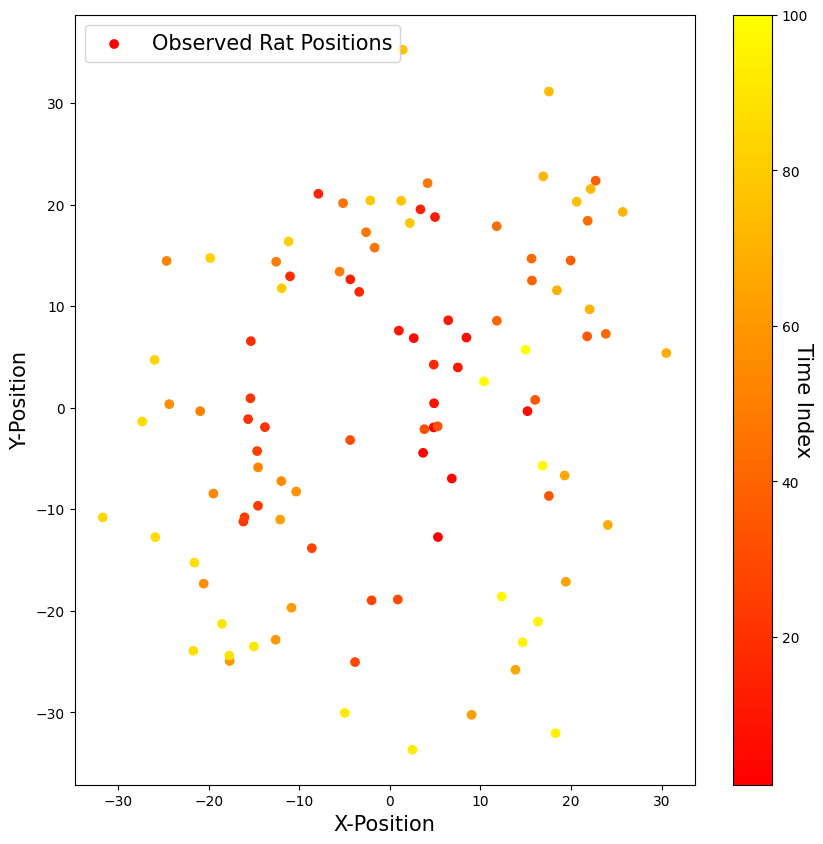

In [84]:
# We start by generating the data our friend collected.
n_timesteps = 100
np.random.seed(1)

transition_matrix = np.array([[1.01, -0.2],[0.2,0.95]])
transition_covariance = 2.0*np.eye(2)

observation_matrix = np.array([[1.0, 0.0],[0.2,1.0]])
observation_covariance = 30.0*np.eye(2)

mu_zero = np.array([1.0,1.2])
cov_zero = 0.1*np.eye(2)

latent_state, observed_state = sample_lds(n_timesteps, transition_matrix, transition_covariance, observation_matrix, observation_covariance, mu_zero, cov_zero)
t_observed = np.arange(len(latent_state))

# Let's plot what our friend collected.
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.show()

You see where your friend is coming from, but it’s really hard to discern an obvious pattern. You decide to model the problem as an LDS where the rat’s dance is the latent state.

- Apply the Kalman filter with the initial guess for the parameters.
- Apply the Kalman filter to the data with 20 steps of expectation-maximization.

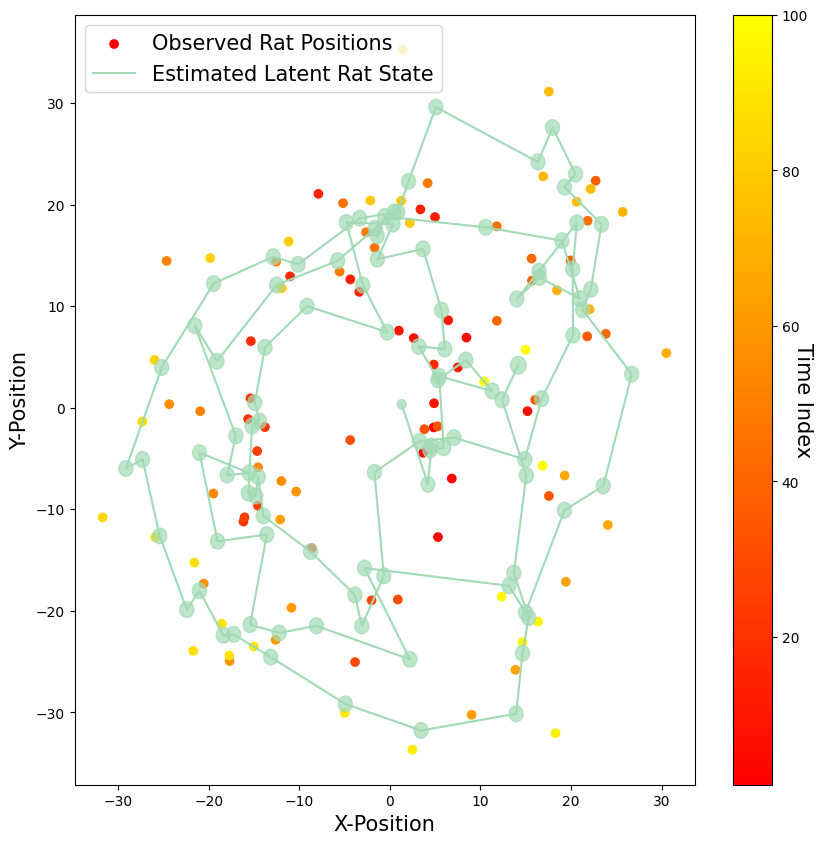

In [85]:
# We'll give you a smart initialization to your EM algorithm for free.
kf = KalmanFilter(sigma_w=3.0, sigma_v=2.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([1.0, 1.2]))

# Get smooth latent states with the initial parameter choices.
smooth_latent_means, smooth_latent_covariances = kf.smooth(observed_state)

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()

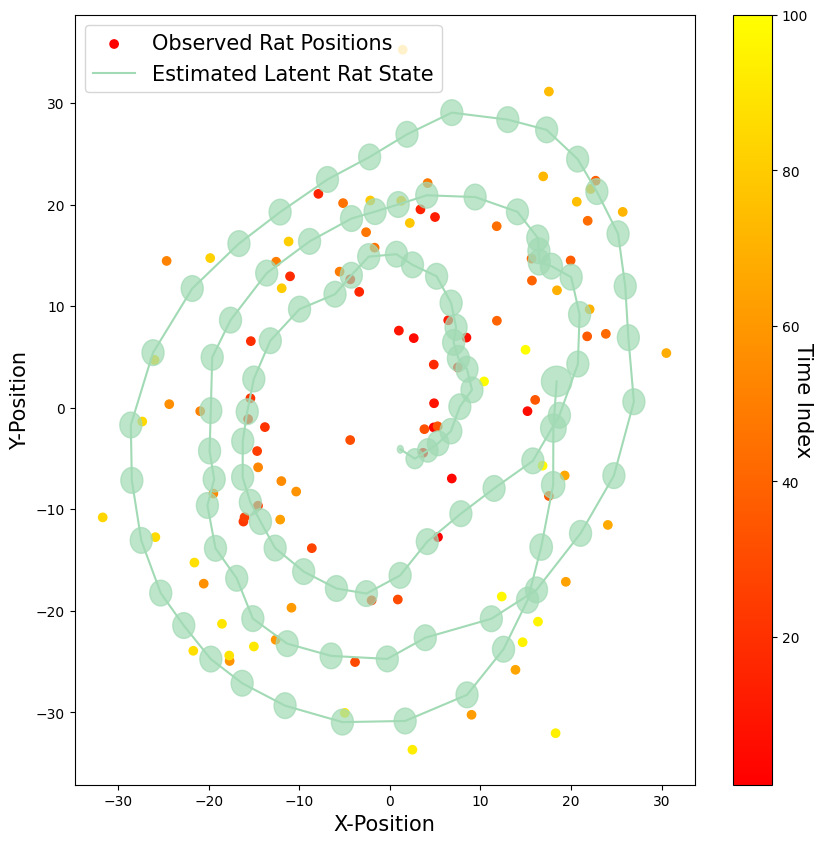

In [86]:
# We'll give you a smart initialization to your EM algorithm for free.
kf = KalmanFilter(sigma_w=3.0, sigma_v=2.0, a=1.0, c=1.0, dim_z=2, dim_x=2, sigma_w_zero=1.0, mu_zero=np.array([1.0, 1.2]))

# --- Run 20 iterations of expectation-maximization ---
kf.expectation_maximization(observed_state, n_iter=20)

#  Run 20 iterations of expectation-maximization and extract the smooth latent states with the optimal parameters.
smooth_latent_means, smooth_latent_covariances = kf.smooth(observed_state)

fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()

There it is! A beautiful dance. This rat was really feeling inspired by the song. For fun let’s cheat and see how well we did of reconstructing the true latent states.

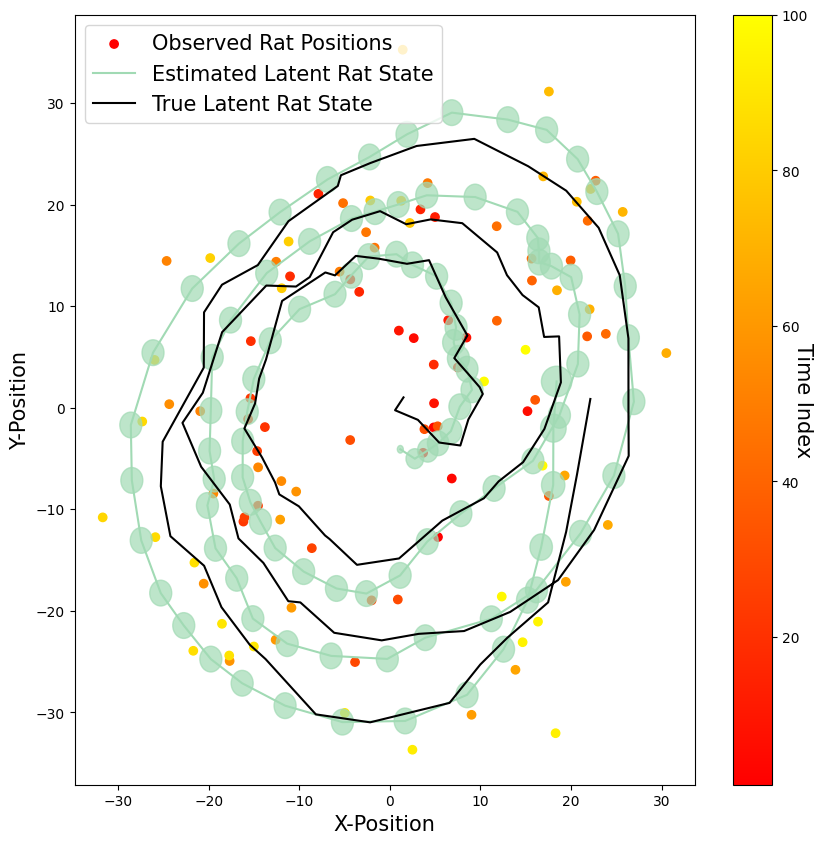

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10,10), dpi=100)
fontsize = 15
plt.scatter(observed_state[:,0],observed_state[:,1], c=t_observed[1:], cmap='autumn', label='Observed Rat Positions')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Time Index', fontsize=fontsize, rotation=270)
plt.xlabel('X-Position', fontsize=fontsize)
plt.ylabel('Y-Position', fontsize=fontsize)
plot_means_and_cov(smooth_latent_means, smooth_latent_covariances, ax=ax, color='#a1dab4', label='Estimated Latent Rat State')
plt.plot(latent_state[:,0], latent_state[:,1], '-', c='k', label='True Latent Rat State')
plt.legend(fontsize=fontsize)
plt.show()